## Monroe vs Mae West

In [10]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

 97%|█████████▋| 33/34 [00:14<00:00,  2.22it/s, loss=0.536]

In [19]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/monroe-mae/"
sz=224
arch=resnet50
bs=10

In [20]:
!ls {PATH}/train

mae  monroe


In [33]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)

In [29]:
!rm data/monroe-mae/valid/mae/67._giphy.gif.gif

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 13/14 [00:01<00:00,  8.12it/s, loss=7.02]


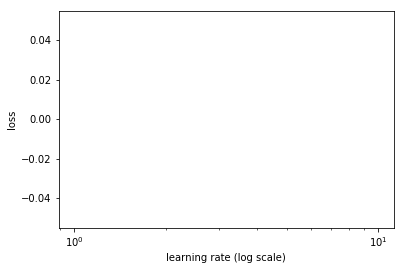

In [34]:
learn.lr_find()
learn.sched.plot()

In [36]:
learn.fit(7e-3, 3, cycle_len=1)
#learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.284304   0.31575    0.758333  
    1      0.274691   0.279595   0.875                     
    2      0.282809   0.269138   0.875                     



[0.26913813, 0.875]

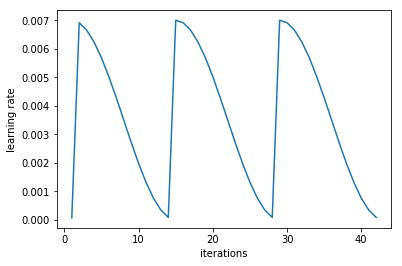

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save('resnet50-last-layer-26-875')

In [39]:
learn.unfreeze()

In [40]:
lrs = np.array([1e-5, 1e-4, 1e-3])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 13/14 [00:02<00:00,  6.02it/s, loss=5.99] 


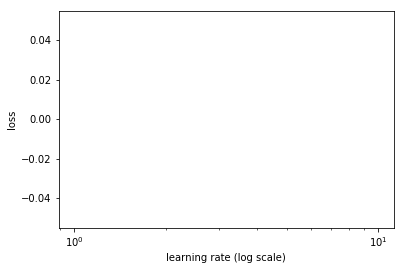

In [43]:

learn.lr_find(lrs/100)
learn.sched.plot()

In [44]:
learn.load('resnet50-last-layer-26-875')

In [45]:
learn.fit(lrs/10, 1, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.460144   0.31418    0.816667  
    1      0.474151   0.37203    0.9                       
    2      0.483138   0.308552   0.9                       
    3      0.468052   0.351559   0.875                     
    4      0.499781   0.267773   0.9                       



[0.26777264, 0.8999999910593033]

In [46]:
learn.save('resnet50-all-layer-26-89')

In [ ]:
learn.load('resnet50-all-layer-26-89')

In [50]:
learn.save('resnet50-last-layer-44-09')

In [75]:
learn.save('resnet50-last-layer-37-87')

In [64]:
learn.save('resnet50-last-layer-52-80')

In [57]:
learn.save('resnet50-last-layer-48-75')

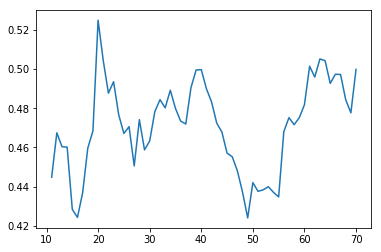

In [47]:
learn.sched.plot_loss()

In [48]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 13/14 [00:02<00:00,  5.93it/s, loss=6.16] 


In [71]:
learn.unfreeze()
lr=np.array([1e-5,1e-4,1e-3])

In [75]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      2.538169   1.45082    0.65      
    1      2.131015   0.652992   0.75                     
    2      1.954832   0.838228   0.775                    



[0.83822763, 0.77500000000000002]

In [76]:
learn.save('mwmm-resnet-unfreeze-2')

In [9]:
learn.load('224_all_50')

## Analyzing results

In [49]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[15  1]
 [ 3 14]]


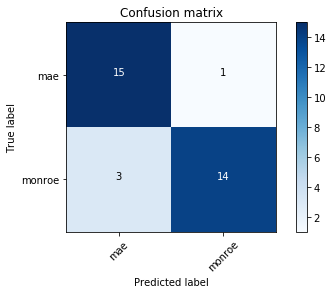

In [50]:
plot_confusion_matrix(cm, data.classes)

In [51]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plot_test_with_title(idxs, title):
    imgs = np.stack([data.test_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.test_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [52]:
data.classes

['mae', 'monroe']

wrong


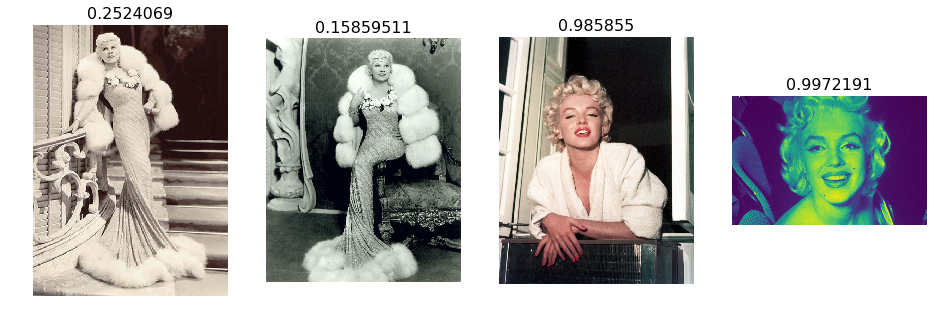

In [60]:
plot_val_with_title(rand_by_correct(True), "wrong")

Most correct monroe


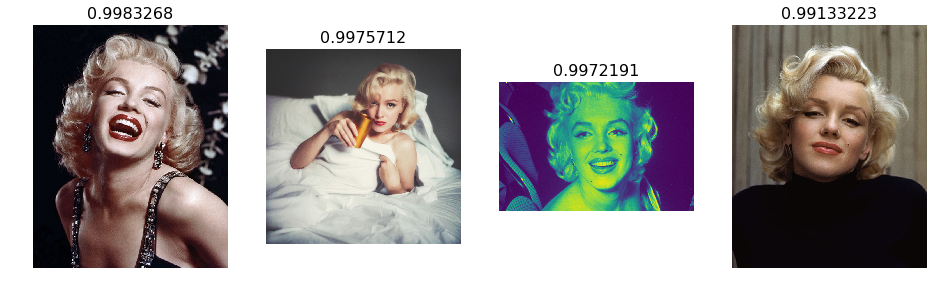

In [55]:
plot_val_with_title(most_by_correct(1, True), "Most correct monroe")

Most correct mae


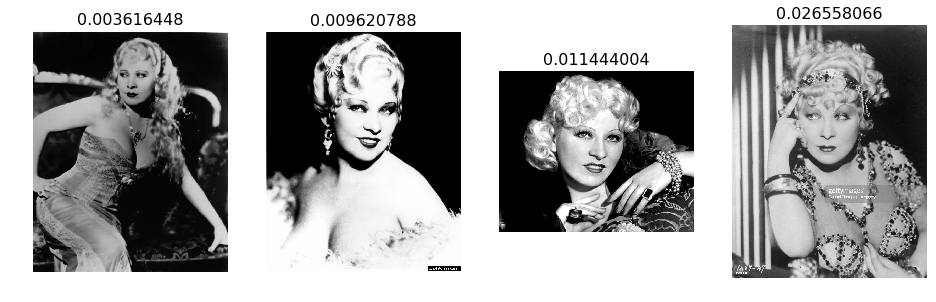

In [56]:
plot_val_with_title(most_by_correct(0, True), "Most correct mae")

In [13]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4, test_name='test')
learn.set_data(data)

## Analyzing results

In [14]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

Test results


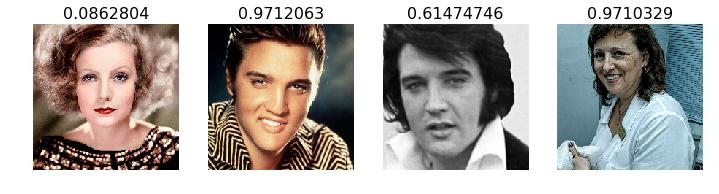

In [17]:
plot_test_with_title(rand_by_mask(probs==probs), "Test results")